In [1]:
#!pip install torch-geometric
!pip install metric-learn
#!pip install pygraphviz
#import torch
#import torch.nn as nn
from scipy.spatial import cKDTree
#import torch.nn.functional as F
#import torch_geometric.utils as pyg_utils
#from torch_geometric.utils.convert import to_networkx
#from networkx.drawing.nx_agraph import to_agraph
#import torch.nn.parallel
#import torch_geometric
#import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#import multiprocessing
#import multiprocessing as mp
from metric_learn import MMC
from sklearn.neighbors import KDTree
#from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
#from concurrent.futures import ThreadPoolExecutor
import time
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.3 MB/s eta 0:00:00


In [4]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

    
# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbors_list.append(neighbors)

# # Print neighbors for each point
# for i, neighbors in enumerate(neighbors_list):
#     print(f"Neighbors for point {i}: {neighbors}")

    
# Extract MuonID1 column
muon_id_column = input_data['muonid']

# # Print points in X_transformed with their corresponding MuonID1 values
# for i, muon_id in enumerate(muon_id_column):
#     print(f"Point {i} - MuonID1: {muon_id}")

    
# # Print neighbors and their MuonID1 values for each point
# for i, neighbors in enumerate(neighbors_list):
#     print(f"Point {i} (MuonID1: {muon_id_column[i]}) has neighbors with MuonID1 values:")
#     print(f"    - Point {i} (MuonID1: {muon_id_column[i]})")
#     for neighbor_index in neighbors:
#         print(f"    - Point {neighbor_index} (MuonID1: {muon_id_column[neighbor_index]})")

# Create a list to store data for CSV
csv_data = []

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Create a dictionary for each point
    point_dict = {
        'Point': i,
        'MuonID1': muon_id_column[i],
        'Neighbours': str(neighbors),  # Convert list to string
        'Neighbour_MuonIDs': str([muon_id_column[n] for n in neighbors])  # Convert list to string
    }
    csv_data.append(point_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Save DataFrame to CSV file
df.to_csv('point_neighbour_data.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")
        

Execution time: 1120.4718039035797 seconds


In [8]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=10000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

    
# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbors_list.append(neighbors)

# Create a list to store data for CSV
csv_data = []

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Count occurrences of each Muon ID
muon_id_counts = muon_id_column.value_counts()

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Convert list of neighbors to string with comma separation
    neighbors_str = ', '.join(map(str, neighbors))
    
    # Convert list of neighbor MuonIDs to string with comma separation
    neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
    
    # Add hit number column
    hit_number = muon_id_counts[muon_id_column[i]]
    
    # Create a dictionary for each point
    point_dict = {
        'Point': i,
        'MuonID1': muon_id_column[i],
        'Hit_Number': hit_number,
        'Neighbours': neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': neighbour_muon_ids_str  # Convert list to string
    }
    csv_data.append(point_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Function to calculate percentage of neighbors with the same MuonID
def calculate_percentage(row):
    neighbours = ast.literal_eval(row['Neighbours'])
    neighbour_muon_ids = ast.literal_eval(row['Neighbour_MuonIDs'])
    muon_id1 = row['MuonID1']
    
    if isinstance(neighbour_muon_ids, int):  # Check if neighbour_muon_ids is an integer
        return 0  # Return 0 if neighbour_muon_ids is an integer
    
    if muon_id1 in neighbour_muon_ids:
        total_neighbours = len(neighbours)
        same_muon_id_neighbours = neighbour_muon_ids.count(muon_id1)
        percentage = (same_muon_id_neighbours / total_neighbours) * 100
        return percentage
    else:
        return 0

# Apply the function to each row and create a new column 'Percentage_Same_MuonID'
df['Percentage_Same_MuonID'] = df.apply(calculate_percentage, axis=1)

# Save DataFrame to CSV file
df.to_csv('point_neighbour_data_with_percentage_and_hit_number.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 4.933184623718262 seconds


In [9]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=10000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbors_list.append(neighbors)

# Create a list to store data for CSV
csv_data = []

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Count occurrences of each Muon ID
muon_id_counts = muon_id_column.value_counts()

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Convert list of neighbors to string with comma separation
    neighbors_str = ', '.join(map(str, neighbors))
    
    # Convert list of neighbor MuonIDs to string with comma separation
    neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
    
    # Add hit number column
    hit_number = muon_id_counts[muon_id_column[i]]
    
    # Calculate percentage of neighbors with the same MuonID
    total_neighbours = len(neighbors)
    same_muon_id_neighbours = neighbour_muon_ids_str.count(str(muon_id_column[i]))
    percentage_same_muon_id = (same_muon_id_neighbours / total_neighbours) * 100
    
    # Calculate percentage of MuonID1 occurrences among neighbors
    percentage = (same_muon_id_neighbours / hit_number) * 100
    
    # Create a dictionary for each point
    point_dict = {
        'Point': i,
        'MuonID1': muon_id_column[i],
        'Hit_Number': hit_number,
        'Neighbours': neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': neighbour_muon_ids_str,  # Convert list to string
        'Percentage_Same_MuonID': percentage_same_muon_id,
        'Percentage': percentage  # Add Percentage column
    }
    csv_data.append(point_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Save DataFrame to CSV file
df.to_csv('percentage_track.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 3.359602928161621 seconds


In [2]:
# Read the first 30,000 rows of the CSV file
df = pd.read_csv('/kaggle/input/including-999-time-sorted/new_file_with_999_time_sorted.csv', nrows=30000)

# Count the unique muonid values
unique_muonid_count = df['muonid'].nunique()

print("Number of unique muonid in the first 30,000 rows:", unique_muonid_count)



Number of unique muonid in the first 30,000 rows: 711


In [17]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/old-without-999/old_file_withou_999.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbors_list.append(neighbors)

# Create a list to store data for CSV
csv_data = []

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Count occurrences of each Muon ID
muon_id_counts = muon_id_column.value_counts()

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Convert list of neighbors to string with comma separation
    neighbors_str = ', '.join(map(str, neighbors))
    
    # Convert list of neighbor MuonIDs to string with comma separation
    neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
    
    # Calculate percentage of neighbors with the same MuonID
    total_neighbours = len(neighbors)
    same_muon_id_neighbours = neighbour_muon_ids_str.split(', ').count(str(muon_id_column[i]))
    percentage_same_muon_id = (same_muon_id_neighbours / total_neighbours) * 100
    
    # Get hit number for the current MuonID_QP
    hit_number = muon_id_counts[muon_id_column[i]]
    
    # Calculate percentage of MuonID1 occurrences among neighbors
    if hit_number != 0:
        percentage = (same_muon_id_neighbours / hit_number) * 100
    else:
        percentage = 0
    
    # Create a dictionary for each point
    point_dict = {
        'QPoint': i,
        'MuonID_QP': muon_id_column[i],
        'Hit_Number': hit_number,
        'Neighbours': neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': neighbour_muon_ids_str,  # Convert list to string
        '%_Same_MuonID_within_neighbours': percentage_same_muon_id,
        '%final_hitnumber': percentage  # Add Percentage column
    }
    csv_data.append(point_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Save DataFrame to CSV file
df.to_csv('bef_er_old_file.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 13.474001169204712 seconds


In [19]:
# Read the first 30,000 rows of the CSV file
df = pd.read_csv('/kaggle/input/old-without-999/old_file_withou_999.csv', nrows=30000)

# Count the unique muonid values
unique_muonid_count = df['muonid'].nunique()

print("Number of unique muonid in the first 30,000 rows:", unique_muonid_count)




Number of unique muonid in the first 30,000 rows: 2382


In [20]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/old-without-999/old_file_withou_999.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbors_list.append(neighbors)

# Create a list to store data for CSV
csv_data = []

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Count occurrences of each Muon ID
muon_id_counts = muon_id_column.value_counts()

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Convert list of neighbors to string with comma separation
    neighbors_str = ', '.join(map(str, neighbors))
    
    # Convert list of neighbor MuonIDs to string with comma separation
    neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
    
    # Calculate percentage of neighbors with the same MuonID
    total_neighbours = len(neighbors)
    same_muon_id_neighbours = neighbour_muon_ids_str.split(', ').count(str(muon_id_column[i]))
    percentage_same_muon_id = (same_muon_id_neighbours / total_neighbours) * 100
    
    # Get hit number for the current MuonID_QP
    hit_number = muon_id_counts[muon_id_column[i]]
    
    # Calculate percentage of MuonID1 occurrences among neighbors
    if hit_number != 0:
        percentage = (same_muon_id_neighbours / hit_number) * 100
    else:
        percentage = 0
    
    # Create a dictionary for each point
    point_dict = {
        'QPoint': i,
        'MuonID_QP': muon_id_column[i],
        'Hit_Number': hit_number,
        'Neighbours': neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': neighbour_muon_ids_str,  # Convert list to string
        '%_Same_MuonID': percentage_same_muon_id,
        'track_purity': percentage  # Add Percentage column
    }
    csv_data.append(point_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Save DataFrame to CSV file
df.to_csv('before_ed_ref_old.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 13.011120080947876 seconds


In [31]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/before-new-purity/QP_neigh_percentage_new_file.csv')

# Calculate the average of the 'Percentage_Same_Muon_ID' column
percentage_same_muonid_avg = df['%_Same_MuonID_within_neighbours'].mean()

# Calculate the average of the 'Track_Purity' column
track_purity_avg = df['%final_hitnumber'].mean()

print(f"The average of 'Percentage_Same_Muon_ID' column is: {percentage_same_muonid_avg}")
print(f"The average of 'Track_Purity' column is: {track_purity_avg}")

The average of 'Percentage_Same_Muon_ID' column is: 70.56738020349803
The average of 'Track_Purity' column is: 23.878453578952794


In [5]:
# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=10000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbors_list.append(neighbors)

# Create a list to store data for CSV
csv_data = []

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Filtering neighbors based on probability
    valid_neighbors = []
    query_pos_z = input_data_1.iloc[i]['z']
    query_time = input_data_1.iloc[i]['t']
    for neighbor_idx in neighbors:
        neighbor_pos_z = input_data_1.iloc[neighbor_idx]['z']
        neighbor_time = input_data_1.iloc[neighbor_idx]['t']
        
        # Calculate z_diff_sqr and time_diff_sqr
        z_diff_sqr = (query_pos_z - neighbor_pos_z) ** 2
        time_diff_sqr = (query_time - neighbor_time) ** 2
        
        # Calculate probability
        prob = sigmoid(100 * z_diff_sqr) * sigmoid(time_diff_sqr)
        if prob >= 0.5:
            valid_neighbors.append(neighbor_idx)
    
    # Convert list of valid neighbors to string with comma separation
    valid_neighbors_str = ', '.join(map(str, valid_neighbors))
    
    # Convert list of valid neighbor MuonIDs to string with comma separation
    valid_neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in valid_neighbors]))
    
    # Create a dictionary for each point
    point_dict = {
        'QPoint': i,
        'MuonID_QP': muon_id_column[i],
        'Neighbours': valid_neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': valid_neighbour_muon_ids_str,  # Convert list to string
    }
    csv_data.append(point_dict)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Save DataFrame to CSV file
df.to_csv('QP_neigh_filtered_1st10kROWS__.csv', index=False, columns=['QPoint', 'MuonID_QP', 'Neighbours', 'Neighbour_MuonIDs'])

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 34.63805890083313 seconds


In [22]:
# #EDGE_REF_BEGIN

# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/old-without-999/old_file_withou_999.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_dict = {'Point': [], 'Neighbour': [], 'MuonID_Point': [], 'MuonID_Neighbour': [], 'Time_Difference': [], 'Delta_Z': []}
muon_id_column = input_data['muonid']
time_column = input_data['t']
z_column = input_data['z']
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    for neighbor in neighbors:
        neighbors_dict['Point'].append(i)
        neighbors_dict['Neighbour'].append(neighbor)
        neighbors_dict['MuonID_Point'].append(muon_id_column[i])
        neighbors_dict['MuonID_Neighbour'].append(muon_id_column[neighbor])
        time_difference = abs(time_column[i] - time_column[neighbor])
        neighbors_dict['Time_Difference'].append(time_difference)
        delta_z = abs(z_column[i] - z_column[neighbor])
        neighbors_dict['Delta_Z'].append(delta_z)
#         label = 1 if muon_id_column[i] == muon_id_column[neighbor] else 0
#         neighbors_dict['Label'].append(label)

# Create DataFrame from the dictionary
df = pd.DataFrame(neighbors_dict)

# Calculate maximum values for Time_Difference and Delta_Z
max_time_difference = df['Time_Difference'].max()
max_delta_z = df['Delta_Z'].max()

# Normalize Time_Difference and Delta_Z columns
df['normalized_delta_t'] = df['Time_Difference'] / max_time_difference
df['normalized_delta_z'] = df['Delta_Z'] / max_delta_z

# Drop original Time_Difference and Delta_Z columns
df.drop(columns=['Time_Difference', 'Delta_Z'], inplace=True)

# Save DataFrame to CSV file
df.to_csv('Ed_normalized_old_no999_30000.csv', index=False)


# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 73.70954966545105 seconds


In [23]:
# Load your CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/for-pred-old-no999/Ed_normalized_old_no999_30000.csv')

# Load the saved Random Forest Classifier model from the pickle file
model_file_path = '/kaggle/input/random-forest/random_forest_model.pkl'
with open(model_file_path, 'rb') as file:
    model = pickle.load(file)


# Select features and target variable
X = df[['normalized_delta_z', 'normalized_delta_t']]

# Make predictions
predictions = model.predict(X)

# Add predictions to the DataFrame
df['predictions'] = predictions

# Save DataFrame to CSV
df.to_csv('predictions_on_old_no999_edg_ref.csv', index=False)



In [24]:
# Load your CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/for-removing-zero-no999-old/predictions_on_old_no999_edg_ref.csv')

# Filter out rows with predictions equal to 0
df_filtered = df[df['predictions'] == 1]

# Save the filtered DataFrame to a new CSV file
df_filtered.to_csv('filtered_data_with_pred_1_only_old_no999_file.csv', index=False)

In [25]:
# Load your CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/pred-1-old-no999/filtered_data_with_pred_1_only_old_no999_file.csv')

# Group the data by 'Point' and aggregate 'Neighbour', 'MuonID_Neighbour', 'normalized_delta_t', 'normalized_delta_z', and 'predictions' into lists
grouped = df.groupby('Point').agg({
    'Neighbour': list,
    'MuonID_Point': 'first',
    'MuonID_Neighbour': list,
    'normalized_delta_t': list,
    'normalized_delta_z': list,
    'predictions': list
}).reset_index()

# Rename columns for clarity
grouped.rename(columns={'Neighbour': 'Neighbours', 'MuonID_Neighbour': 'MuonID_Neighbours'}, inplace=True)

# Save DataFrame to CSV
grouped.to_csv('transformed_data_pred_1_oldno999_file_only_edg_ref.csv', index=False)

In [26]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/for-final-prec-purity-old-no999/transformed_data_pred_1_oldno999_file_only_edg_ref.csv')

# Define a function to calculate the percentage of same Muon ID among neighbors
def calculate_percentage(row):
    muon_id_point = row['MuonID_Point']
    muon_id_neighbors = eval(row['MuonID_Neighbours'])  # Convert string representation of list to a list
    total_neighbors = len(muon_id_neighbors)
    same_muon_id_count = muon_id_neighbors.count(muon_id_point)
    return (same_muon_id_count / total_neighbors) * 100 if total_neighbors > 0 else 0

# Apply the function to each row and create a new column 'Percentage_Same_Muon_ID'
df['Percentage_Same_Muon_ID'] = df.apply(calculate_percentage, axis=1)

# Save the updated DataFrame to a new CSV file
df.to_csv('purity_old_no999.csv', index=False)

print("File saved as 'updated_file.csv'")






File saved as 'updated_file.csv'


In [27]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/for-final-prec-purity-old-no999/transformed_data_pred_1_oldno999_file_only_edg_ref.csv')

# Define a function to calculate the percentage of same Muon ID among neighbors
def calculate_percentage(row):
    muon_id_point = row['MuonID_Point']
    muon_id_neighbors = eval(row['MuonID_Neighbours'])  # Convert string representation of list to a list
    total_neighbors = len(muon_id_neighbors)
    same_muon_id_count = muon_id_neighbors.count(muon_id_point)
    return (same_muon_id_count / total_neighbors) * 100 if total_neighbors > 0 else 0

# Apply the function to each row and create a new column 'Percentage_Same_Muon_ID'
df['Percentage_Same_Muon_ID'] = df.apply(calculate_percentage, axis=1)

# Calculate hit number
hit_counts = df['MuonID_Point'].value_counts()
df['Hit_Number'] = df['MuonID_Point'].map(hit_counts)

# Define a function to calculate track purity
def calculate_track_purity(row):
    same_muon_id_count = row['MuonID_Neighbours'].count(str(row['MuonID_Point']))
    return (same_muon_id_count / row['Hit_Number']) * 100 if row['Hit_Number'] > 0 else 0

# Apply the function to each row and create a new column 'Track_Purity'
df['Track_Purity'] = df.apply(calculate_track_purity, axis=1)

# Save the updated DataFrame to a new CSV file
df.to_csv('purity_no999_oldfile.csv', index=False)

print("File saved as 'updated_file.csv'")

File saved as 'updated_file.csv'


In [28]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/average/purity_no999_oldfile.csv')

# Calculate the average of the 'Percentage_Same_Muon_ID' column
percentage_same_muonid_avg = df['Percentage_Same_Muon_ID'].mean()

# Calculate the average of the 'Track_Purity' column
track_purity_avg = df['Track_Purity'].mean()

print(f"The average of 'Percentage_Same_Muon_ID' column is: {percentage_same_muonid_avg}")
print(f"The average of 'Track_Purity' column is: {track_purity_avg}")

The average of 'Percentage_Same_Muon_ID' column is: 99.35045111481799
The average of 'Track_Purity' column is: 16.151180246111288


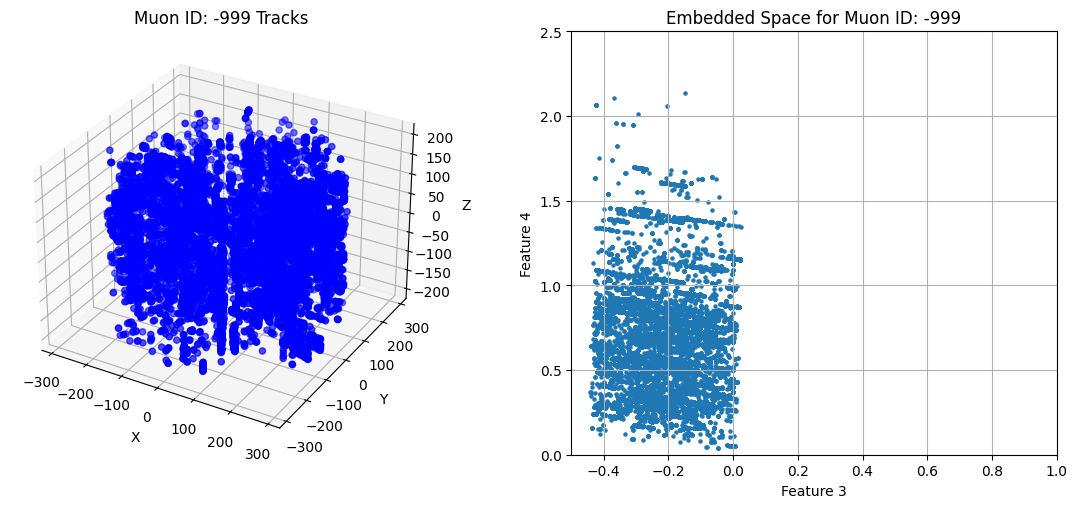

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import pickle

# Step 1: Read CSV file into a Pandas DataFrame and take only the first 10,000 rows
df = pd.read_csv('/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv')

# Step 2: Choose a particular muonid
selected_muonid = -999

# Step 3: Filter DataFrame for the selected muonid
selected_data = df[df['muonid'] == selected_muonid]

# Step 4: Extract x, y, z values for tracks visualization
x_values = selected_data['x']
y_values = selected_data['y']
z_values = selected_data['z']

# Step 5: Plot tracks (x, y, z)
fig = plt.figure(figsize=(12, 6))  # Adjust figure size if needed
ax1 = fig.add_subplot(121, projection='3d')  # Using subplot to plot tracks and embedded space side by side
ax1.scatter(x_values, y_values, z_values, c='b', marker='o')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Muon ID: ' + str(selected_muonid) + ' Tracks')

# Select only the desired columns (x, y, z, t)
input_data_1 = df[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Step 6: Filter transformed data based on the selected muonid
selected_X_transformed = X_transformed[df['muonid'] == selected_muonid]

# Step 7: Plot embedded space for the selected muonid
ax2 = fig.add_subplot(122)
ax2.scatter(selected_X_transformed[:, 2], selected_X_transformed[:, 3], s=5)

ax2.set_xlabel('Feature 3')
ax2.set_ylabel('Feature 4')
ax2.set_title('Embedded Space for Muon ID: ' + str(selected_muonid))
ax2.grid(True)

# Set axis limits
ax2.set_xlim(-0.5, 1)
ax2.set_ylim(0, 2.5)

plt.tight_layout(pad=4.0)  # Increase padding between subplots


# Specify the path where you want to save the image
output_path = '/kaggle/working/-999.png'  # Output directory on Kaggle
plt.savefig(output_path, dpi=300)  # dpi parameter sets the resolution

plt.show()


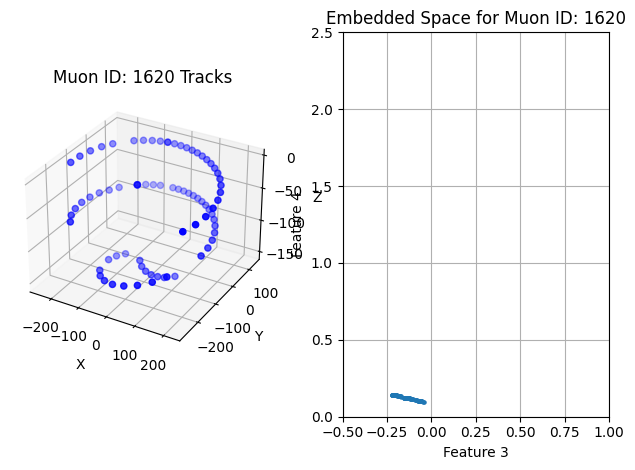

In [3]:
#VISUALIZING THE TRACKS AND EMBEDDED SPACE

# Step 1: Read CSV file into a Pandas DataFrame and take only the first 10,000 rows
df = pd.read_csv('/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv')

# Step 2: Choose a particular muonid
selected_muonid = 1620

# Step 3: Filter DataFrame for the selected muonid
selected_data = df[df['muonid'] == selected_muonid]

# Step 4: Extract x, y, z values for tracks visualization
x_values = selected_data['x']
y_values = selected_data['y']
z_values = selected_data['z']

# Step 5: Plot tracks (x, y, z)
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')  # Using subplot to plot tracks and embedded space side by side
ax.scatter(x_values, y_values, z_values, c='b', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Muon ID: ' + str(selected_muonid) + ' Tracks')


# Select only the desired columns (x, y, z, t)
input_data_1 = df[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)
# Step 6: Filter transformed data based on the selected muonid
selected_X_transformed = X_transformed[df['muonid'] == (selected_muonid)]

# Step 7: Plot embedded space for the selected muonid
plt.subplot(122)
plt.scatter(selected_X_transformed[:, 2], selected_X_transformed[:, 3], s=5)
plt.xlabel('Feature 3')
plt.ylabel('Feature 4')
plt.title('Embedded Space for Muon ID: ' + str(selected_muonid))
plt.grid(True)
# Set axis limits
plt.xlim(-0.5, 1)
plt.ylim(0, 2.5)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
len(x_values)
selected_data.to_csv("output.txt")

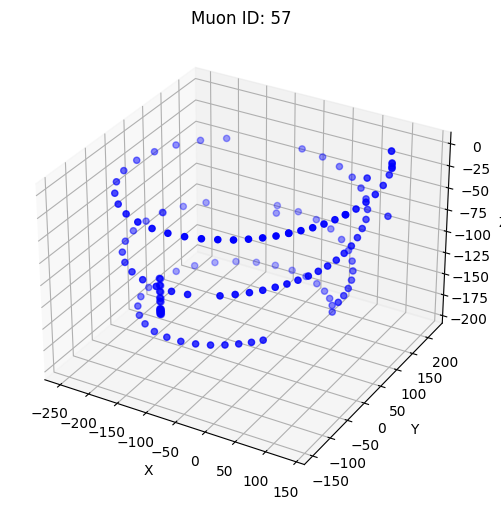

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Read CSV file into a Pandas DataFrame and take only the first 10,000 rows
df = pd.read_csv('/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv')

# Choose a particular muonid
selected_muonid = 57

# Filter DataFrame for the selected muonid
selected_data = df[df['muonid'] == selected_muonid]

# Extract x, y, z values for tracks visualization
x_values = selected_data['x']
y_values = selected_data['y']
z_values = selected_data['z']

# Plot tracks (x, y, z) and save as image
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_values, y_values, z_values, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Muon ID: ' + str(selected_muonid))
plt.savefig('/kaggle/working/muon_tracks7.png')
plt.show()

# Select only the desired columns (x, y, z, t)
# input_data_1 = df[['x', 'y', 'z', 't']]

# # Extract columns for scaling
# columns_to_scale = ['x', 'y', 'z', 't']
# data_to_scale = input_data_1[columns_to_scale]

# # Scale the data
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data_to_scale)

# # Load the trained MMC model from the pickle file
# model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
# with open(model_file_path, 'rb') as file:
#     trained_mmc_model = pickle.load(file)

# # Transform the input data using the trained MMC model
# X_transformed = trained_mmc_model.transform(scaled_data)

# # Filter transformed data based on the selected muonid
# selected_X_transformed = X_transformed[df['muonid'] == selected_muonid]

# # Plot embedded space for the selected muonid and save as image
# plt.figure(figsize=(8, 6))
# plt.scatter(selected_X_transformed[:, 2], selected_X_transformed[:, 3], s=5)
# # plt.xlabel('Feature 3')
# # plt.ylabel('Feature 4')
# plt.title('Embedded Space for Muon ID: ' + str(selected_muonid))
# plt.grid(True)
# # Set axis limits
# plt.xlim(-0.5, 1)
# plt.ylim(0, 2.5)
# plt.savefig('/kaggle/working/embedded_space_muonid_7' + str(selected_muonid) + '.png')
# plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import zipfile

# Read CSV file into a Pandas DataFrame and take only the first 10,000 rows
df = pd.read_csv('/kaggle/input/testing3lakh/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv')

# Output directory for saving images
output_dir = '/kaggle/working/muon_tracks'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all muon IDs
for selected_muonid in range(1, 10000):
    # Filter DataFrame for the selected muonid
    selected_data = df[df['muonid'] == selected_muonid]
    
    # Extract x, y, z values for tracks visualization
    x_values = selected_data['x']
    y_values = selected_data['y']
    z_values = selected_data['z']
    
    # Plot tracks (x, y, z) and save as image
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_values, y_values, z_values, c='b', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Muon ID: ' + str(selected_muonid))
    plt.savefig(os.path.join(output_dir, f'muon_track_{selected_muonid}.png'))
    plt.close(fig)

# Create a zip file containing all the saved images
with zipfile.ZipFile('/kaggle/working/muon_tracks.zip', 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)


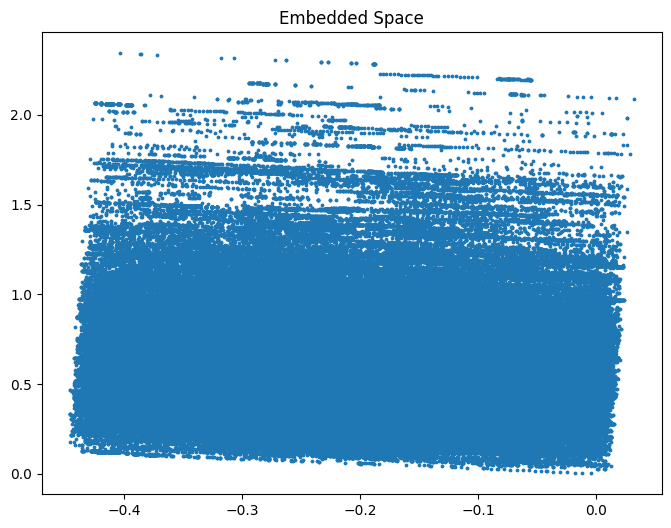

In [7]:
#VISUALISING THE EMBEDED SPACE

plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:, 2], X_transformed[:, 3], s=3)
# plt.xlabel('Feature 3')
# plt.ylabel('Feature 4')
plt.title('Embedded Space')
#plt.grid(True)

# Specify the path where you want to save the image
output_path = '/kaggle/working/embedded_space.png'  # Output directory on Kaggle
plt.savefig(output_path, dpi=300)  # dpi parameter sets the resolution

plt.show()

In [5]:
# Load the CSV file into a DataFrame
file_path = "/kaggle/input/last-with-label/last_with_label.csv"
df = pd.read_csv(file_path)

# Separate rows with label 0 and label 1
label_0 = df[df['Label'] == 0]
label_1 = df[df['Label'] == 1]

# Sample the same number of rows for label 1 as there are for label 0
label_1_sampled = label_1.sample(n=len(label_0), random_state=42)

# Concatenate the sampled rows with the original label 0 rows
balanced_df = pd.concat([label_0, label_1_sampled])

# Shuffle the DataFrame to mix the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced DataFrame as a CSV file
balanced_df.to_csv('balanced_data.csv', index=False)

# Now balanced_df contains an equal number of rows for label 0 and label 1

In [3]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/balanceddatafortraining/balanced_data (1).csv')

# Select the columns you want to scale
columns_to_scale = ['Time_Difference', 'Delta_Z']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Save the modified DataFrame to a new CSV file
df.to_csv("scaled_data_input_for_training.csv", index=False)

In [4]:
#NEW TRAINING MODEL BINARY CLASSIFICATION

# Load your CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/scaleddatafortraininginput/scaled_data_input_for_training.csv')

# Select features and target variable
X = df[['Point', 'Neighbour', 'Time_Difference', 'Delta_Z']]
y = df['Label']

# Instantiate the Logistic Regression model
model = LogisticRegression()

# Train the model on the entire dataset
model.fit(X, y)

# Save the trained model to a file in the output directory
output_path = "/kaggle/working/binary_logistic_scaled.pkl"
with open(output_path, 'wb') as f:
    pickle.dump(model, f)
    
    
    
# # Predict on the testing set
# y_pred = model.predict(X_test)

# # Create a DataFrame to store the predictions
# predictions_df = pd.DataFrame({'Predictions': y_pred})

# # Save the DataFrame as a CSV file
# predictions_df.to_csv('predictionstraining.csv', index=False)

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

In [4]:
#100

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/100data-csv/RecoOutPileup_TimeMod_uniform_1_100recohitfile.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (pos_x, pos_y, pos_z, time)
input_data_1 = input_data[['pos_x', 'pos_y', 'pos_z', 'time']]

# Extract columns for scaling
columns_to_scale = ['pos_x', 'pos_y', 'pos_z', 'time']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_dict = {'Point': [], 'Neighbour': [], 'Time_Difference': [], 'Delta_Z': [], }
time_column = input_data['time']
z_column = input_data['pos_z']
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    for neighbor in neighbors:
        neighbors_dict['Point'].append(i)
        neighbors_dict['Neighbour'].append(neighbor)
        time_difference = abs(time_column[i] - time_column[neighbor])
        neighbors_dict['Time_Difference'].append(time_difference)
        delta_z = abs(z_column[i] - z_column[neighbor])
        neighbors_dict['Delta_Z'].append(delta_z)
        

# Create DataFrame from the dictionary
df = pd.DataFrame(neighbors_dict)

# Save DataFrame to CSV file
df.to_csv('/kaggle/working/delta_z_delta_t_100.csv', index=False)

In [6]:
# Read the CSV file
df = pd.read_csv('/kaggle/input/without-scaling-100-deltas/Testing_new_delta_z_delta_t_100.csv')

# Extract the columns to be scaled
columns_to_scale = ['Time_Difference', 'Delta_Z']
data_to_scale = df[columns_to_scale]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Replace the original columns with the scaled data
df['Time_Difference'] = scaled_data[:, 0]
df['Delta_Z'] = scaled_data[:, 1]

# Save the DataFrame to a new CSV file
df.to_csv('scaled_dataofdelta100.csv', index=False)

In [5]:
# Load the saved logistic regression model from the pickle file
with open('/kaggle/input/binarylogistic240424/binary_logistic_scaled.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Load the new CSV file into a DataFrame
new_data = pd.read_csv('/kaggle/input/100filescaled/scaled_dataofdelta100.csv')

# Extract features from the new data
X_new = new_data[['Point', 'Neighbour', 'Time_Difference', 'Delta_Z']]

# Make predictions using the loaded model
predictions = loaded_model.predict(X_new)

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame({'Predictions': predictions})

# Save the DataFrame as a CSV file
predictions_df.to_csv('predictions.csv', index=False)

In [6]:
#WITHOUT KDTREE

# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)
# Move tensors to GPU
device = torch.device('cuda')
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

# Define the radius for connecting nodes
radius = 0.001

# Define the function to construct a graph for a given point
def construct_graphs(X_transformed_tensor, radius, device):
    num_points = X_transformed_tensor.shape[0]
    pairwise_distances = torch.cdist(X_transformed_tensor, X_transformed_tensor)  # Compute pairwise distances
    graphs = []
    for i in range(num_points):
        neighbors_indices = torch.nonzero(pairwise_distances[i] < radius).squeeze()
        edge_index = torch.tensor([[i] * len(neighbors_indices), neighbors_indices], dtype=torch.long, device=device)
        x = X_transformed_tensor[neighbors_indices]
        graphs.append(Data(x=x, edge_index=edge_index))
    return graphs

# Create graphs directly on GPU
graphs = construct_graphs(X_transformed_tensor, radius, device)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

OutOfMemoryError: CUDA out of memory. Tried to allocate 483.13 GiB. GPU 0 has a total capacty of 15.89 GiB of which 15.25 GiB is free. Process 2900 has 660.00 MiB memory in use. Of the allocated memory 367.33 MiB is allocated by PyTorch, and 8.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Move tensors to GPU
device = torch.device('cuda')

# Convert X_transformed to a PyTorch tensor and move to GPU
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32, device=device)

# KDTree - Construct on CPU
tree = KDTree(X_transformed, leaf_size=2)

# Define the radius for connecting nodes
radius = 0.001

# Define a function to construct a graph for a given point
def construct_graph_for_point(point_index):
    neighbors_indices = tree.query_radius(X_transformed[point_index].reshape(1, -1), r=radius)[0]  # Use CPU for querying neighbors
    neighbors_indices = neighbors_indices[neighbors_indices != point_index]
    # Filter out-of-bounds indices
    neighbors_indices = neighbors_indices[neighbors_indices < len(X_transformed)]
    
    edge_index = torch.tensor([[point_index] * len(neighbors_indices), neighbors_indices], dtype=torch.long, device=device)
    x = X_transformed_tensor[neighbors_indices]
    return Data(x=x, edge_index=edge_index)


# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

# Define the number of threads to utilize
num_threads = 40

# Create graphs using ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    graphs = list(executor.map(construct_graph_for_point, range(len(X_transformed))))




Execution time: 1.4959533214569092 seconds


In [8]:
#KD LINE OUTSIDE THE GRAPH FUNCTION

# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Move tensors to GPU
device = torch.device('cuda')

# Convert X_transformed to a PyTorch tensor and move to GPU
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32, device=device)

# KDTree - Construct on CPU
tree = KDTree(X_transformed, leaf_size=2)

# Define the radius for connecting nodes
radius = 0.001

# Pre-compute nearest neighbors for each point
all_neighbors_indices = [tree.query_radius(X_transformed[i].reshape(1, -1), r=radius)[0] for i in range(len(X_transformed))]

# Define a function to construct a graph for a given point
def construct_graph_for_point(point_index):
    neighbors_indices = all_neighbors_indices[point_index]
    neighbors_indices = neighbors_indices[neighbors_indices != point_index]
    # Filter out-of-bounds indices
    neighbors_indices = neighbors_indices[neighbors_indices < len(X_transformed)]
    
    edge_index = torch.tensor([[point_index] * len(neighbors_indices), neighbors_indices], dtype=torch.long, device=device)
    x = X_transformed_tensor[neighbors_indices]
    return Data(x=x, edge_index=edge_index)


# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

# Define the number of threads to utilize
num_threads = 40

# Create graphs using ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    graphs = list(executor.map(construct_graph_for_point, range(len(X_transformed))))

Execution time: 114.41709971427917 seconds


KeyboardInterrupt: 

In [6]:
#BASE CODEE !!!!


# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)



    
# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)
# Move tensors to GPU
device = torch.device('cuda')
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Define the radius for connecting nodes
radius = 0.001

# Define a function to construct a graph for a given point
def construct_graph_for_point(point_index):
    neighbors_indices = tree.query_radius(X_transformed[point_index].reshape(1, -1), r=radius)[0]
    neighbors_indices = neighbors_indices[neighbors_indices != point_index]
    # Filter out-of-bounds indices
    neighbors_indices = neighbors_indices[neighbors_indices < len(X_transformed)]
    
    edge_index = np.array([[point_index] * len(neighbors_indices), neighbors_indices])
    x = torch.tensor(X_transformed[neighbors_indices], dtype=torch.float32).to(device)
    data = Data(x=x, edge_index=torch.tensor(edge_index, dtype=torch.long).to(device))
    return data

# Construct graphs for each point and store them
graphs = []
for i in range(len(X_transformed)):
    graph_data = construct_graph_for_point(i)
    graphs.append(graph_data)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

# # Specify the file name to save the pickle file
# pickle_file_name = 'graphpickle.pkl'

# # Combine the file name with the output directory path
# pickle_file_path = f'/kaggle/working/graphpickle'

# # Save the graphs data as a pickle file
# with open(pickle_file_path, 'wb') as file:
#     pickle.dump(graphs, file)

# print("Graph data saved as pickle file:", pickle_file_path)


# # Print details of each graph
# for i, graph_data in enumerate(graphs):
#     print("Graph", i+1)
#     print("Number of nodes:", graph_data.num_nodes)
#     print("Node features (x):", graph_data.x)
#     print("Edge index:", graph_data.edge_index)
#     print()


Execution time: 193.05955338478088 seconds


In [ ]:
# Visualize the first 10 graphs
for i in range(min(10, len(graphs))):  # Limit visualization to the first 10 graphs or fewer if there are fewer graphs
    graph_data = graphs[i]

    # Convert edge_index to networkx graph
    nx_graph = nx.Graph()
    nx_graph.add_edges_from(graph_data.edge_index.t().tolist())

    # Draw the graph using matplotlib
    plt.figure(figsize=(8, 8))
    plt.title("Graph Visualization (Graph {})".format(i+1))
    nx.draw(nx_graph, with_labels=True, node_color='skyblue', node_size=800, edge_color='gray', linewidths=1, font_size=10)
    plt.show()

In [5]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Move tensors to GPU
device = torch.device('cuda')
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32, device=device)

# Construct KDTree on CPU
tree = cKDTree(X_transformed)

# Define the radius for connecting nodes
radius = 0.001

# Define a function to construct a graph for a given point
def construct_graph_for_point(point_index):
    neighbors_indices = tree.query_ball_point(X_transformed[point_index], r=radius)
    neighbors_indices.remove(point_index)
    neighbors_indices = torch.tensor(neighbors_indices, dtype=torch.long, device=device)
    
    edge_index = torch.stack([torch.full_like(neighbors_indices, point_index), neighbors_indices], dim=0)
    x = X_transformed_tensor[neighbors_indices]
    return Data(x=x, edge_index=edge_index)

# Construct graphs for each point and store them
graphs = [construct_graph_for_point(i) for i in range(len(X_transformed))]

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 67.10206174850464 seconds


In [3]:
#50 SEC

# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Move tensors to GPU
device = torch.device('cuda')

# Convert X_transformed to a PyTorch tensor and move to GPU
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32, device=device)

# KDTree - Construct on CPU
tree = KDTree(X_transformed, leaf_size=2)

# Define the radius for connecting nodes
radius = 0.001

# Query neighbors using KDTree in one go
neighbors_indices = tree.query_radius(X_transformed, r=radius)

# Filter out-of-bounds indices
valid_neighbors_indices = [indices[indices != i] for i, indices in enumerate(neighbors_indices)]

# Construct graph data on GPU
graphs = []
for i, indices in enumerate(valid_neighbors_indices):
    if len(indices) > 0:
        edge_index = torch.tensor([[i] * len(indices), indices], dtype=torch.long, device=device)
        x = X_transformed_tensor[indices]
        graph_data = Data(x=x, edge_index=edge_index)
        graphs.append(graph_data)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 51.422144651412964 seconds


In [ ]:
# Define a function to convert Data object to NetworkX graph
def data_to_networkx(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index.cpu().numpy()
    
    # Create an empty undirected graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(num_nodes))
    
    # Add edges
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        G.add_edge(src.item(), dst.item())
    
    return G

# Visualize the first 10 graphs
for i in range(min(10, len(graphs))):
    graph_data = graphs[i]
    nx_graph = data_to_networkx(graph_data)

    # Draw the graph using matplotlib
    plt.figure(figsize=(8, 8))
    plt.title("Graph Visualization (Graph {})".format(i+1))
    nx.draw(nx_graph, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=1, font_size=6)
    plt.show()

In [25]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Move tensors to GPU
device = torch.device('cuda')

# Convert X_transformed to a PyTorch tensor and move to GPU
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32, device=device)

# KDTree - Construct on CPU
tree = KDTree(X_transformed, leaf_size=2)

# Define the radius for connecting nodes
radius = 0.001

# Query neighbors using KDTree in one go
neighbors_indices = tree.query_radius(X_transformed, r=radius)

# Filter out-of-bounds indices
valid_neighbors_indices = [indices[indices != i] for i, indices in enumerate(neighbors_indices)]

# Construct edge index tensor for all points
edge_indices = torch.cat([torch.tensor([[i] * len(indices), indices], dtype=torch.long, device=device) for indices in valid_neighbors_indices], dim=1)

# Extract node features (x) for all points
x = torch.cat([X_transformed_tensor[indices] for indices in valid_neighbors_indices], dim=0)

# Create the graph data for all points
graphs = [Data(x=x, edge_index=edge_indices)]

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 41.036482095718384 seconds


In [28]:
# Function to create a graph for a single point
def create_graph_for_point(point_index, X_transformed, radius):
    # Calculate Euclidean distances between the current point and all other points
    distances = torch.sqrt(torch.sum((X_transformed - X_transformed[point_index])**2, dim=1))
    # Find neighbor indices within the specified radius
    neighbors_indices = torch.nonzero(distances < radius).squeeze(1)
    # Exclude the current point from neighbors
    neighbors_indices = neighbors_indices[neighbors_indices != point_index]
    # Construct edge indices
    edge_index = torch.stack([torch.full_like(neighbors_indices, point_index), neighbors_indices], dim=0)
    # Extract node features (x) for the current point and its neighbors
    x = X_transformed[neighbors_indices]
    return Data(x=x, edge_index=edge_index)

# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/realtesting/test01.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Move tensors to GPU
device = torch.device('cuda')
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32, device=device)

# Define the radius for connecting nodes
radius = 0.001

# Create a list to store the graph data
graphs = []

# Iterate over each point in X_transformed and create graphs in parallel
with torch.no_grad():
    for i in range(len(X_transformed)):
        graph = create_graph_for_point(i, X_transformed_tensor, radius)
        graphs.append(graph)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 149.24740743637085 seconds


In [ ]:
# MUONID1 plotting


# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/testing-data-set/testing.csv'

# Read the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path)

# Select only the desired columns (X1, Y1, Z1, T1)
input_data_1 = input_data[['X1', 'Y1', 'Z1', 'T1']]

# Extract columns for scaling
columns_to_scale = ['X1', 'Y1', 'Z1', 'T1']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)
X_transformed_tensor = torch.tensor(X_transformed, dtype=torch.float32)

# Extract MuonID1 column from the CSV file
muon_id_column = input_data['MuonID1']

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

def construct_graph_for_point(point_index, muon_id):
    # Query neighbors for the given point
    neighbors = tree.query_radius(X_transformed[point_index].reshape(1, -1), r=0.01)[0]
    
    # Create a graph object
    G = nx.Graph()

    # Add nodes to the graph with MuonID1 as node attribute
    for neighbor in neighbors:
        muon_id_neighbor = muon_id[neighbor]
        G.add_node(neighbor, MuonID1=muon_id_neighbor)
    
    # Create edges between nodes based on neighbor indices
    for neighbor in neighbors:
        if neighbor != point_index:
            G.add_edge(point_index, neighbor)
    
    return G

# Plot individual graphs for each point with MuonID1 values of the point and its neighbors
for i in range(len(X_transformed)):
    # Construct graph for the current point
    graph = construct_graph_for_point(i, muon_id_column)
    
    # Get MuonID1 value for the current point
    muon_id_current = muon_id_column[i]

    # Get MuonID1 values of neighbors
    neighbors_muon_id = {neighbor: graph.nodes[neighbor]['MuonID1'] for neighbor in graph.nodes()}

    # Display MuonID1 values of the point and its neighbors
    print(f"Point {i}: MuonID1 = {muon_id_current}, Neighbors' MuonID1 = {neighbors_muon_id}")

    # Plot the graph
    plt.figure(figsize=(6, 6))
    nx.draw(graph, with_labels=True)
    plt.title(f'Graph for point {i+1}')
    plt.show()

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Code execution completed in {elapsed_time} seconds")